In [79]:
import cartopy.crs as ccrs
import cartopy.util as cutil
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


In [159]:
ds = xr.open_dataset("../../../data/SST.nc")
ds

<xarray.Dataset> Size: 173MB
Dimensions:  (nlat: 2400, nlon: 3600)
Coordinates:
    time     object 8B ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (nlat, nlon) float32 35MB ...
    ULONG    (nlat, nlon) float64 69MB ...
    ULAT     (nlat, nlon) float64 69MB ...
Attributes:
    title:         hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 34115 2012-01-25 22:35:19Z njn01 $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2024-08-20 at 22:47:26.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  107120
    tavg_sum:      86399.99999999974

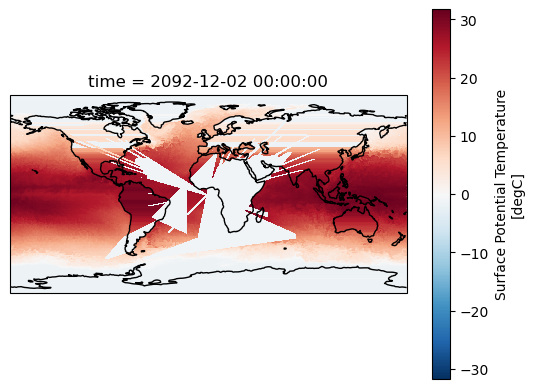

In [156]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

dsi = ds.isel(nlat=slice(0,2400,10), nlon=slice(0,3600,10))
dsi = xr.concat((dsi, dsi.isel(nlon=0)), dim='nlon')
dsi = xr.concat((dsi.isel(nlat=0,nlon=slice(None,None,-1)), dsi, dsi.isel(nlat=-1,nlon=slice(None,None,-1))), dim='nlat')
dsi = dsi.set_coords(('ULONG','ULAT'))
dsi.SST.plot.pcolormesh(x='ULONG', y='ULAT', transform=ccrs.PlateCarree())
ax.coastlines()


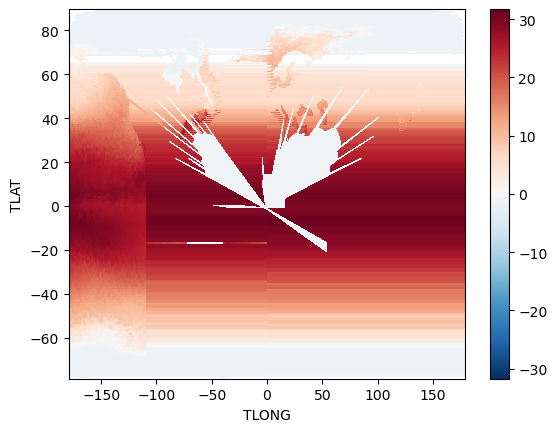

In [162]:
def add_cyclic_POP(da):
    """ add a cyclis point to a 2D POP output field to remove missing data line in cartopy """
    assert 'TLAT' in da.coords
    assert 'TLONG' in da.coords
    lats = np.zeros((len(da.nlat),len(da.nlon)+1))
    lons = np.zeros((len(da.nlat),len(da.nlon)+1))
    data = np.zeros((len(da.nlat),len(da.nlon)+1))
    lats[:,:-1] = da.TLAT
    lons[:,:-1] = da.TLONG
    data[:,:-1] = da.data
    lats[:,-1]  = da.TLAT[:,0]
    lons[:,-1]  = da.TLONG[:,0]
    data[:,-1]  = da.data[:,0]
    dims = ['nlat','nlon']
    new_da = xr.DataArray(data=data, dims=dims, coords={'TLAT':(dims,lats), 'TLONG':(dims,lons)})
    return new_da

dsi = ds.isel(nlat=slice(0,2400,10), nlon=slice(0,3600,10))
SST = dsi.SST.assign_coords({'TLONG':dsi.ULONG, 'TLAT':dsi.ULAT})
SST = add_cyclic_POP(SST)
SST.plot(x='TLONG', y='TLAT')

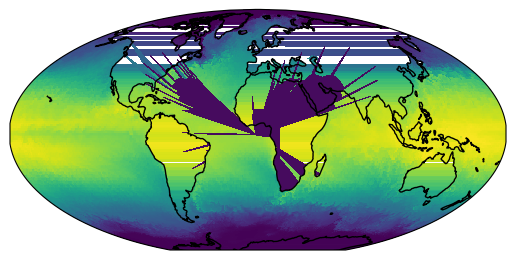

In [184]:
import numpy as np
import xarray as xr
import cartopy
import cmocean
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

file_ex_ocn_ctrl = '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/spinup_pd_maxcores_f05_t12/OUTPUT/ocn/hist/monthly/spinup_pd_maxcores_f05_t12.pop.h.0200-01.nc'
KE = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).KE.isel(z_t=0).squeeze()  # open with xarray, but you can plot any 2D array, e.g. an numpy array you load differently
SST = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).TEMP.isel(z_t=0).squeeze()  # squeeze removes time dimension which cartopy sees as a third dimension
MASK = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).REGION_MASK

# figure with two subplots
f = plt.figure(figsize=(12,5))

# orthographic projection of kinetic energy
ax = f.add_axes([.02,.05,.4,.9], projection=ccrs.Orthographic(central_longitude=-30, central_latitude=20))  # this projection sets the figure projection
ax.set_title('Orthographic projection')
im = ax.pcolormesh(KE.TLONG, KE.TLAT, np.log(KE).where(MASK>0),  # MASK is usually necessary for the high resolution, otherwise you coudl get plotting artifacts
                   transform=ccrs.PlateCarree(), cmap='cmo.solar')  # this transformation just says lats/lons are in degrees
plt.colorbar(im, ax=ax, orientation='horizontal', extend='both', label=r'log(KE) log[cm$^2$ s$^{-1}$]')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')

# platecaree projection of SST
ax = f.add_axes([.45,.05,.53,.9], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Plate Carrée projection')
im = ax.pcolormesh(SST.TLONG, SST.TLAT, SST.where(MASK>0),
                   transform=ccrs.PlateCarree(), cmap='cmo.thermal')
plt.colorbar(im, ax=ax, orientation='horizontal', extend='both', label=r'SST [$^\circ\!$C]')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS, zorder=3, edgecolor='blue')